# 03 — Modeling: Census Income 💼📊

<p align="left">
  <img alt="ID3 Algorithm" src="https://img.shields.io/badge/ID3-Decision%20Tree-0A81D1">
  <img alt="scikit-learn" src="https://img.shields.io/badge/scikit--learn-Baseline-F7931E">
  <img alt="Status" src="https://img.shields.io/badge/Notebook-Modeling-1e90ff">
</p>

**Purpose**: Predict `high_income` (<=50K vs >50K). Validate a from-scratch **ID3** on categorical-binned features and compare against a **scikit-learn DecisionTree** baseline on one-hot + numeric features.  
**Author**: <span style="color:#FF6B6B"><b>Noëlla Buti</b></span>

---

### 🚦 Results Snapshot (Test set)
- **ID3 (categorical-binned)** → acc **0.8189**, P/R/F1 (for `>50K`) **0.663 / 0.538 / 0.594**  
- **DecisionTree (OHE + numeric, min_samples_leaf=50)** → acc **0.8263**, P/R/F1 **0.680 / 0.557 / 0.612**  
- **Notes**
  - Pruned ID3 tree (depth 3) for readability is saved.
  - Full trees are large; regularization (e.g., `min_samples_leaf`) helps generalization.

<details>
  <summary><b>📁 Artifacts (click to expand)</b></summary>

- ID3 tree (full): `reports/assets/census_id3_tree.png`  
- ID3 tree (pruned): `reports/assets/census_id3_tree_pruned.png`  
- Sklearn tree (baseline): `reports/assets/census_sklearn_tree.png`  
- Sklearn tree (best): `reports/assets/census_sklearn_tree_best.png`  
- Feature importances: `reports/assets/census_dt_feature_importance.png`  
- Metrics JSON: `reports/metrics_census.json`  

</details>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/

import os, json
ASSETS = "id3-census-income/reports/assets"
REPORTS = "id3-census-income/reports"
os.makedirs(ASSETS, exist_ok=True)
os.makedirs(REPORTS, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


## 1. Load processed datasets

In [2]:
import pandas as pd

# For ID3 (categorical)
train_cat = pd.read_csv("data/processed/census_train_categorical.csv")
test_cat  = pd.read_csv("data/processed/census_test_categorical.csv")

# For sklearn (ML)
train_ml = pd.read_csv("data/processed/census_train_ml.csv")
test_ml  = pd.read_csv("data/processed/census_test_ml.csv")

target = "high_income"
train_cat.head(), train_ml.head()

(          workclass    education      marital_status         occupation  \
 0         State-gov      college       Never-married       Adm-clerical   
 1  Self-emp-not-inc      college  Married-civ-spouse    Exec-managerial   
 2           Private  somecollege            Divorced  Handlers-cleaners   
 3           Private  pre-college  Married-civ-spouse  Handlers-cleaners   
 4           Private      college  Married-civ-spouse     Prof-specialty   
 
     relationship   race     sex native_country age_bin education_years_bin  \
 0  Not-in-family  White    Male  United-States   35-44                9-12   
 1        Husband  White    Male  United-States   35-44                9-12   
 2  Not-in-family  White    Male  United-States   35-44                9-12   
 3        Husband  Black    Male  United-States   35-44                9-12   
 4           Wife  Black  Female           Cuba   35-44                9-12   
 
      hours_bin high_income  
 0  standard_40       <=50K  
 1  st

## 2. From-scratch ID3 Helpers (Reuse from PlayTennis/Emails)

In [3]:
import pandas as pd
from collections import Counter
import math

# Guards: make sure processed dataframes exist
assert 'train_cat' in globals() and 'test_cat' in globals(), \
    "Load processed census files first (train_cat, test_cat)."

target = "high_income"

In [4]:
# ID3 helpers
def entropy(series: pd.Series) -> float:
    counts = Counter(series); n = sum(counts.values())
    if n == 0: return 0.0
    return -sum((c/n) * math.log2(c/n) for c in counts.values() if c)

def information_gain(df: pd.DataFrame, feature: str, target: str) -> float:
    H = entropy(df[target])
    weights = df[feature].value_counts(normalize=True)
    cond = sum(w * entropy(df[df[feature]==v][target]) for v, w in weights.items())
    return H - cond

def majority_label(series: pd.Series):
    return series.mode().iloc[0]

def best_feature_by_ig(df: pd.DataFrame, target: str) -> str:
    feats = [c for c in df.columns if c != target]
    gains = {f: information_gain(df, f, target) for f in feats}
    return max(gains, key=gains.get)

def build_id3(df: pd.DataFrame, target: str, max_depth=None, depth=0):
    # pure node
    if len(df[target].unique()) == 1:
        return df[target].iloc[0]
    # depth stop
    if max_depth is not None and depth >= max_depth:
        return majority_label(df[target])
    # no features left
    feats_left = [c for c in df.columns if c != target]
    if not feats_left:
        return majority_label(df[target])
    # choose best feature
    f = best_feature_by_ig(df, target)
    node = {f: {}}
    # split
    for v in sorted(df[f].dropna().unique()):
        sub = df[df[f] == v]
        node[f][v] = build_id3(sub.drop(columns=[f]), target, max_depth, depth+1) if not sub.empty else majority_label(df[target])
    return node

# robust leaf collector (works for node dicts and branches dicts)
def _collect_leaves_any(obj):
    leaves = []
    stack = [obj]
    while stack:
        cur = stack.pop()
        if isinstance(cur, dict):
            # node form: {"feature": {...}}
            if len(cur) == 1 and isinstance(next(iter(cur.values())), dict):
                stack.append(next(iter(cur.values())))
            else:
                # branches dict: {value: subtree, ...}
                stack.extend(cur.values())
        else:
            leaves.append(cur)
    return leaves

def predict_one(tree, row: dict):
    node = tree
    while isinstance(node, dict):
        (feat, branches), = node.items()
        val = row.get(feat)
        if val in branches:
            node = branches[val]
        else:
            # fallback: majority among reachable leaves under this node
            leaves = _collect_leaves_any(branches)
            return pd.Series(leaves).mode().iloc[0]
    return node

def predict(tree, X: pd.DataFrame):
    return [predict_one(tree, r.to_dict()) for _, r in X.iterrows()]

## 3. Train & Evaluate ID3 (Categorical-Binned)

In [5]:
# Split features/labels
Xtr_id3 = train_cat.drop(columns=[target])
ytr_id3 = train_cat[target]
Xte_id3 = test_cat.drop(columns=[target])
yte_id3 = test_cat[target]

In [6]:
# Build tree and evaluate
tree_id3 = build_id3(train_cat.copy(), target)  # train on training set
yhat_te_id3 = predict(tree_id3, Xte_id3)       # predict on test set
acc_id3 = (pd.Series(yhat_te_id3) == yte_id3).mean()
print("ID3 test accuracy:", round(float(acc_id3), 4))

ID3 test accuracy: 0.8189


## 4. Visualize ID3 tree to Drive

In [7]:
from graphviz import Digraph

def draw_dict_tree(tree):
    def _add(dot, node, parent=None, edge_label=None, idx=[0]):
        if not isinstance(node, dict):
            nid = f"leaf_{idx[0]}"; idx[0]+=1
            dot.node(nid, str(node), shape="box")
            if parent is not None:
                dot.edge(parent, nid, label=str(edge_label))
            return
        (feat, branches), = node.items()
        fid = f"feat_{feat}"
        dot.node(fid, feat, shape="ellipse")
        if parent is not None:
            dot.edge(parent, fid, label=str(edge_label))
        for val, sub in branches.items():
            _add(dot, sub, parent=fid, edge_label=val, idx=idx)
    dot = Digraph()
    _add(dot, tree)
    return dot

dot = draw_dict_tree(tree_id3)
dot.format = "png"
dot.render(f"{ASSETS}/census_id3_tree", cleanup=True)
print(f"Saved ID3 tree to {ASSETS}/census_id3_tree.png")

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.170867 to fit


Saved ID3 tree to id3-census-income/reports/assets/census_id3_tree.png


## 5. Sklearn DecisionTree baseline

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

Xtr_ml = train_ml.drop(columns=[target])
ytr_ml = train_ml[target]
Xte_ml = test_ml.drop(columns=[target])
yte_ml = test_ml[target]

# Start with a slightly-regularized tree to reduce overfitting
dt = DecisionTreeClassifier(random_state=42, min_samples_leaf=30)
dt.fit(Xtr_ml, ytr_ml)

yhat_te_dt = dt.predict(Xte_ml)
acc_dt = accuracy_score(yte_ml, yhat_te_dt)
print("Sklearn DecisionTree test accuracy:", round(float(acc_dt), 4))

Sklearn DecisionTree test accuracy: 0.8258


## 6. Export sklearn tree to Drive (PNG)

In [9]:
from sklearn.tree import export_graphviz
import graphviz

feat_names = list(Xtr_ml.columns)
dot_data = export_graphviz(
    dt,
    out_file=None,
    feature_names=[fn.replace("&","and").replace("<","lt_").replace(">","gt_") for fn in feat_names],
    class_names=["<=50K", ">50K"],
    filled=True, rounded=True, special_characters=False
)
graph = graphviz.Source(dot_data)
graph.format = "png"
graph.render(f"{ASSETS}/census_sklearn_tree", cleanup=True)
print(f"Saved sklearn tree to {ASSETS}/census_sklearn_tree.png")

Saved sklearn tree to id3-census-income/reports/assets/census_sklearn_tree.png


## 7. Quick sweep for min_samples_leaf to see test accuracy trend

In [10]:
from sklearn.metrics import accuracy_score

candidates = [1, 5, 10, 20, 30, 50, 100]
results = []
for m in candidates:
    mdt = DecisionTreeClassifier(random_state=42, min_samples_leaf=m)
    mdt.fit(Xtr_ml, ytr_ml)
    acc = accuracy_score(yte_ml, mdt.predict(Xte_ml))
    results.append((m, acc))

print("min_samples_leaf -> test accuracy")
for m, acc in results:
    print(f"{m:>3} -> {acc:.4f}")

min_samples_leaf -> test accuracy
  1 -> 0.8167
  5 -> 0.8242
 10 -> 0.8261
 20 -> 0.8258
 30 -> 0.8258
 50 -> 0.8263
100 -> 0.8239


## 8. Save metrics snapshot to Drive

In [11]:
metrics = {
    "id3_test_accuracy": float(acc_id3),
    "sklearn_dt_test_accuracy": float(acc_dt),
}
with open(f"{REPORTS}/metrics_census.json", "w") as f:
    json.dump(metrics, f, indent=2)
metrics

{'id3_test_accuracy': 0.8189379824327921,
 'sklearn_dt_test_accuracy': 0.8257918552036199}

## 9. Evaluation (ID3 + sklearn)

In [12]:
from sklearn.metrics import confusion_matrix, classification_report

print("== ID3 (categorical-binned) ==")
print(confusion_matrix(yte_id3, yhat_te_id3))
print(classification_report(yte_id3, yhat_te_id3, digits=3))

print("\n== Sklearn DecisionTree (OHE + numeric) ==")
print(confusion_matrix(yte_ml, yhat_te_dt))
print(classification_report(yte_ml, yhat_te_dt, digits=3))

== ID3 (categorical-binned) ==
[[10316  1014]
 [ 1707  1991]]
              precision    recall  f1-score   support

       <=50K      0.858     0.911     0.883     11330
        >50K      0.663     0.538     0.594      3698

    accuracy                          0.819     15028
   macro avg      0.760     0.724     0.739     15028
weighted avg      0.810     0.819     0.812     15028


== Sklearn DecisionTree (OHE + numeric) ==
[[10376   954]
 [ 1664  2034]]
              precision    recall  f1-score   support

           0      0.862     0.916     0.888     11330
           1      0.681     0.550     0.608      3698

    accuracy                          0.826     15028
   macro avg      0.771     0.733     0.748     15028
weighted avg      0.817     0.826     0.819     15028



## 10. Pruned ID3 tree (readable PNG)

In [13]:
def prune_for_viz(tree, max_depth=3, depth=0):
    if not isinstance(tree, dict):
        return tree
    if depth >= max_depth:
        leaves = _collect_leaves_any(tree)
        return pd.Series(leaves).mode().iloc[0]
    (feat, branches), = tree.items()
    pruned = {feat: {}}
    for val, sub in branches.items():
        pruned[feat][val] = prune_for_viz(sub, max_depth, depth+1)
    return pruned

viz_tree = prune_for_viz(tree_id3, max_depth=3)

from graphviz import Digraph
def draw_dict_tree(tree):
    def _add(dot, node, parent=None, edge_label=None, idx=[0]):
        if not isinstance(node, dict):
            nid = f"leaf_{idx[0]}"; idx[0]+=1
            dot.node(nid, str(node), shape="box")
            if parent is not None: dot.edge(parent, nid, label=str(edge_label))
            return
        (feat, branches), = node.items()
        fid = f"feat_{feat}"
        dot.node(fid, feat, shape="ellipse")
        if parent is not None: dot.edge(parent, fid, label=str(edge_label))
        for val, sub in branches.items():
            _add(dot, sub, parent=fid, edge_label=val, idx=idx)
    dot = Digraph(graph_attr={"ranksep":"0.35", "nodesep":"0.25"})
    _add(dot, tree)
    return dot

dot = draw_dict_tree(viz_tree)
dot.format = "png"
dot.render(f"{ASSETS}/census_id3_tree_pruned", cleanup=True)
print(f"Saved pruned ID3 tree to {ASSETS}/census_id3_tree_pruned.png")

Saved pruned ID3 tree to id3-census-income/reports/assets/census_id3_tree_pruned.png


## 11. Hyperparameter sweep for sklearn tree

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

candidates = [1, 5, 10, 20, 30, 50, 100]
best_m, best_acc = None, -1.0
for m in candidates:
    mdt = DecisionTreeClassifier(random_state=42, min_samples_leaf=m)
    mdt.fit(Xtr_ml, ytr_ml)
    acc = accuracy_score(yte_ml, mdt.predict(Xte_ml))
    if acc > best_acc:
        best_acc, best_m = acc, m

print(f"Best min_samples_leaf={best_m} -> acc={best_acc:.4f}")
dt = DecisionTreeClassifier(random_state=42, min_samples_leaf=best_m).fit(Xtr_ml, ytr_ml)
yhat_te_dt = dt.predict(Xte_ml)  # refresh predictions with best model

Best min_samples_leaf=50 -> acc=0.8263


In [15]:
from sklearn.tree import export_graphviz
import graphviz

feat_names = list(Xtr_ml.columns)
dot_data = export_graphviz(
    dt,
    out_file=None,
    feature_names=[fn.replace("&","and").replace("<","lt_").replace(">","gt_") for fn in feat_names],
    class_names=["<=50K", ">50K"],
    filled=True, rounded=True, special_characters=False
)
graph = graphviz.Source(dot_data)
graph.format = "png"
graph.render(f"{ASSETS}/census_sklearn_tree_best", cleanup=True)
print(f"Saved sklearn (best) tree to {ASSETS}/census_sklearn_tree_best.png")

Saved sklearn (best) tree to id3-census-income/reports/assets/census_sklearn_tree_best.png


## 12. Feature importance PNG

Saved feature importance to id3-census-income/reports/assets/census_dt_feature_importance.png


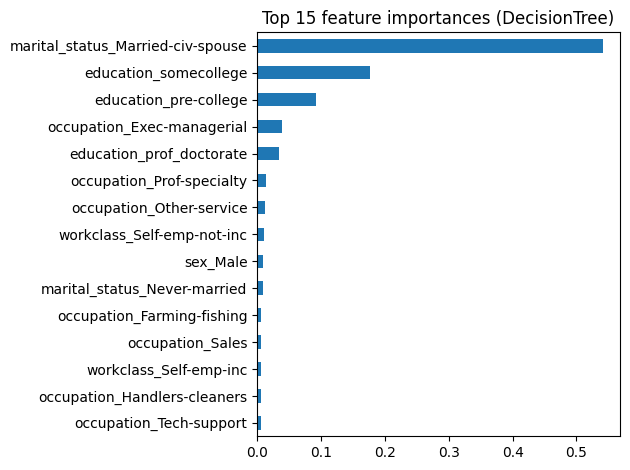

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

imp = pd.Series(dt.feature_importances_, index=Xtr_ml.columns).sort_values(ascending=False).head(15)

plt.figure()
imp.sort_values().plot(kind="barh")
plt.title("Top 15 feature importances (DecisionTree)")
plt.tight_layout()
plt.savefig(f"{ASSETS}/census_dt_feature_importance.png", dpi=150)
print(f"Saved feature importance to {ASSETS}/census_dt_feature_importance.png")

## 13. Rich metrics JSON

In [17]:
from sklearn.metrics import precision_recall_fscore_support

p_id3, r_id3, f1_id3, _ = precision_recall_fscore_support(yte_id3, yhat_te_id3, average="binary", pos_label=">50K")
p_dt,  r_dt,  f1_dt,  _ = precision_recall_fscore_support(yte_ml, yhat_te_dt, average="binary")

metrics = {
    "id3": {
        "test_accuracy": float((pd.Series(yhat_te_id3) == yte_id3).mean()),
        "precision": float(p_id3), "recall": float(r_id3), "f1": float(f1_id3)
    },
    "sklearn_dt": {
        "test_accuracy": float((pd.Series(yhat_te_dt) == yte_ml).mean()),
        "precision": float(p_dt), "recall": float(r_dt), "f1": float(f1_dt),
        "min_samples_leaf": int(best_m) if 'best_m' in globals() else 30
    }
}

with open(f"{REPORTS}/metrics_census.json", "w") as f:
    json.dump(metrics, f, indent=2)
metrics

{'id3': {'test_accuracy': 0.8189379824327921,
  'precision': 0.6625623960066556,
  'recall': 0.5383991346673878,
  'f1': 0.594062360137252},
 'sklearn_dt': {'test_accuracy': 0.8263241948363056,
  'precision': 0.6796565389696169,
  'recall': 0.5565170362358032,
  'f1': 0.6119536128456735,
  'min_samples_leaf': 50}}